## Data processing

This notebook provides a code for basic manipulation of the QFlow lite dataset. It allows to preview the simulated data (Step 1), to convert the full NumPy files to `.csv` format (Step 2), and to convert sub-region files to `.csv` format (Step 3). 

### Step 0: Loading the necessary packages

In [22]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import imp
import glob
import os

import QFlow_class
imp.reload(QFlow_class)
qf = QFlow_class.QFlow()

### Step 1: Previewing the data

The followind code assumes that the data file to be previewd is in the same folder as the current notebook. The sample data file (`sample_data.npy`) has the following structure: 

* `dat.keys() = dict_keys(['physics', 'output', 'V_P2_vec', 'type', 'V_P1_vec'])`
    * `dat['physics']` -- setup of the device stored as dictionary
    * `dat['output']` -- output from the simulation stored as a list (100 $\times$ 100 elements); each element in `data['output']` is a distionary with keys: 
       
       `dat['output'][i].keys() = dict_keys(['state', 'charge', 'sensor', 'current'])`

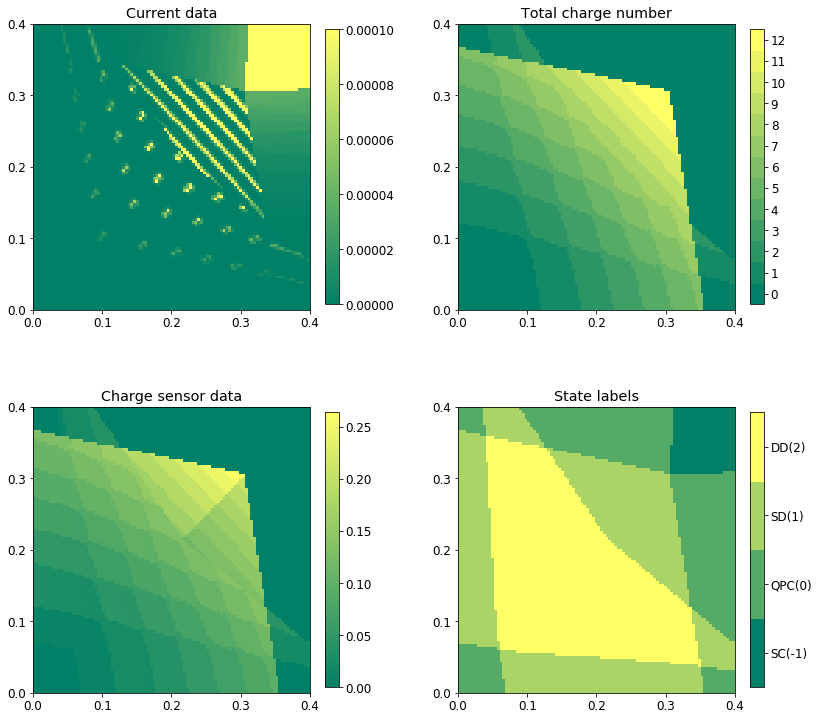

In [185]:
files = glob.glob(os.getcwd()+"/Data/"+"sample_file.npy")
dat = np.load(files[0]).item() 

V_P1 = -dat['V_P1_vec']
V_P2 = -dat['V_P2_vec']
X,Y=np.meshgrid(V_P1,V_P2)
N_v = 100

current_vec = np.array([x['current'] for x in dat['output']]).reshape(N_v,N_v)
charge_vec = np.array([np.sum(x['charge']) for x in dat['output']]).reshape(N_v,N_v)
state_vec = np.array([x['state'] for x in dat['output']]).reshape(N_v,N_v)
sensor_vec = np.array([x['sensor'] for x in dat['output']]).reshape(N_v,N_v,-1)[:,:,0]

matplotlib.rcParams.update({'font.size': 12})

fig, axarr = plt.subplots(2,2, figsize=(11,10))
fig.tight_layout(w_pad=7.0, h_pad=6.0)
plt.yticks(np.arange(0.0, 0.5, 0.1))

cd = axarr[0,0].pcolor(X,Y,current_vec,vmax=1e-4,cmap=cm.summer)
axarr[0,0].set_title('Current data')
axarr[0,0].set_yticks(np.arange(0.0,0.5,0.1))
fig.colorbar(cd, ax = axarr[0,0], fraction=0.045)

tcd = axarr[0,1].pcolor(X,Y,charge_vec,cmap=plt.cm.get_cmap('summer', 13))
axarr[0,1].set_title('Total charge number')
axarr[0,1].set_yticks(np.arange(0.0,0.5,0.1))
fig.colorbar(tcd, ax = axarr[0,1], fraction=0.045, ticks = np.arange(0, 13, 1))
tcd.set_clim(-0.5,12.5)

csd = axarr[1,0].pcolor(X,Y,sensor_vec,cmap=cm.summer)
axarr[1,0].set_title('Charge sensor data')
axarr[1,0].set_yticks(np.arange(0.0,0.5,0.1))
fig.colorbar(csd, ax = axarr[1,0], fraction=0.045)

sd = axarr[1,1].pcolor(X,Y,state_vec,cmap=plt.cm.get_cmap('summer', 4))
axarr[1,1].set_title('State labels')
axarr[1,1].set_yticks(np.arange(0.0,0.5,0.1))
sd.set_clim(-1.5, 2.5)
sd_bar = fig.colorbar(sd, fraction=0.045, ticks = [-1,0,1,2])
sd_bar.ax.set_yticklabels(['SC(-1)', 'QPC(0)', 'SD(1)','DD(2)'])

plt.show()

### Step 2: Creating a sample file

Converting the sample `*.npy` data file with a full sample device to `.csv` for easier preview. 

In [230]:
import csv

files = glob.glob(os.getcwd()+"/Data/sample_file.npy")
dat = np.load(files[0]).item() 
data_dict = dat['output']
 
data = {"V_P1": np.repeat(dat['V_P1_vec'], len(dat['V_P1_vec'])),
        "V_P2": np.tile(dat['V_P2_vec'], len(dat['V_P2_vec'])),         
        "current": np.array([np.sum(x['current']) for x in data_dict]),
        "charge": np.array([np.sum(x['charge']) for x in data_dict]),
        "sensor": np.array([np.sum(x['sensor']) for x in data_dict]),
        "state": np.array([np.sum(x['state']) for x in data_dict])}

with open("Data/sample_data.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(data.keys())
    writer.writerows(zip(*data.values()))

### Step 3: Creating csv files for the subregions

Converting the `*.npy` data files for all subregions into `.csv` format.

In [261]:
import csv

files = glob.glob(os.getcwd()+"/Data/sub_images/"+"*.npy")

for i in range(len(files)):
    dat = np.load(files[i]).item() 
    
    data = {}
    data = {"V_P1": np.repeat(dat['V_P1'], len(dat['V_P1'])),
        "V_P2": np.tile(dat['V_P2'], len(dat['V_P2'])),         
        "current": dat['current_map'].flatten(),
        "charge": dat['net_charge_map'].flatten(),
        "sensor": dat['sensor_map'].flatten(),
        "state": dat['state_map'].flatten()}
    
    with open(os.path.join("Data/sub_images_csv/"+os.path.basename(files[i])[:-4]+".csv"), "w") as f:
        writer = csv.writer(f)
        writer.writerow(data.keys())
        writer.writerows(zip(*data.values()))